# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    return 2 * np.sin(w) * np.cos(w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

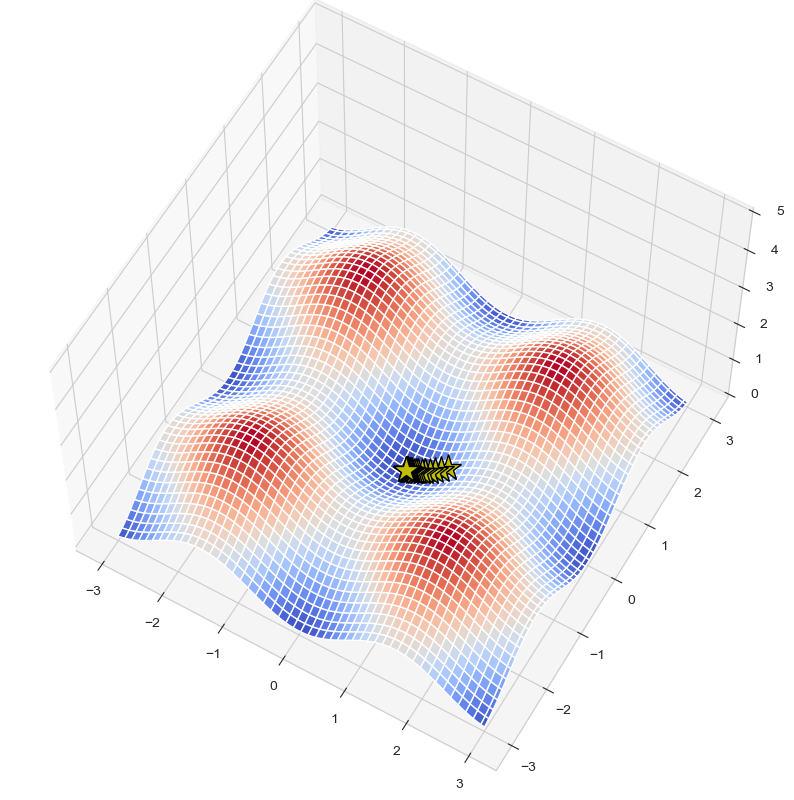

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

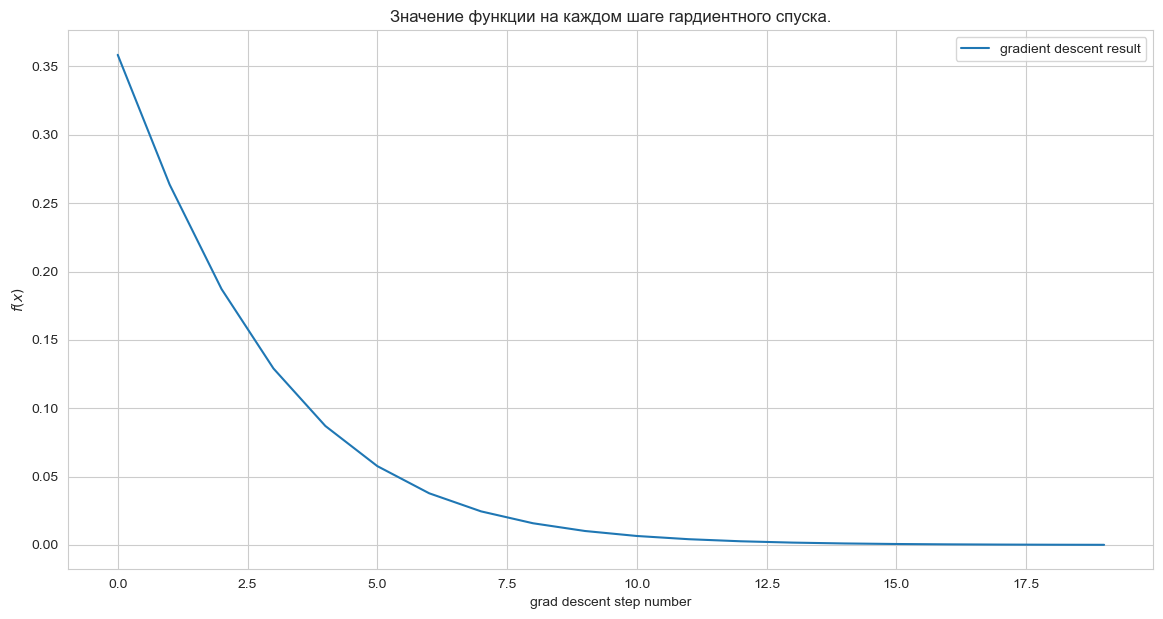

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")

    return np.sum((y_true - y_pred) ** 2)/len(y_true)


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 2 / len(y_true) * (X.T @ (y_pred - y_true))


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

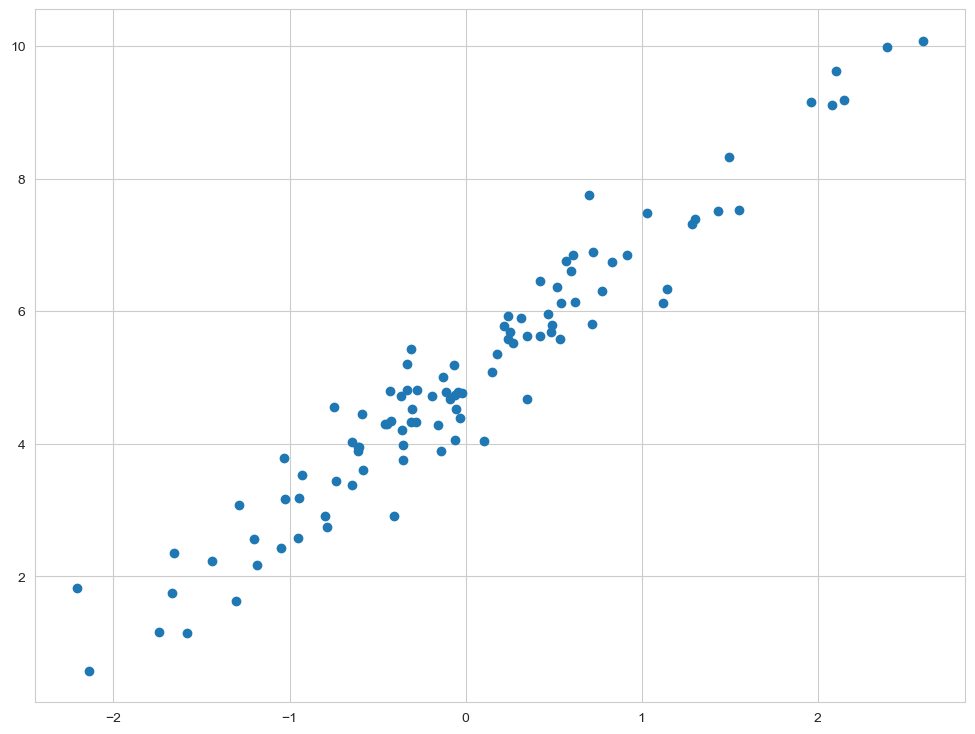

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

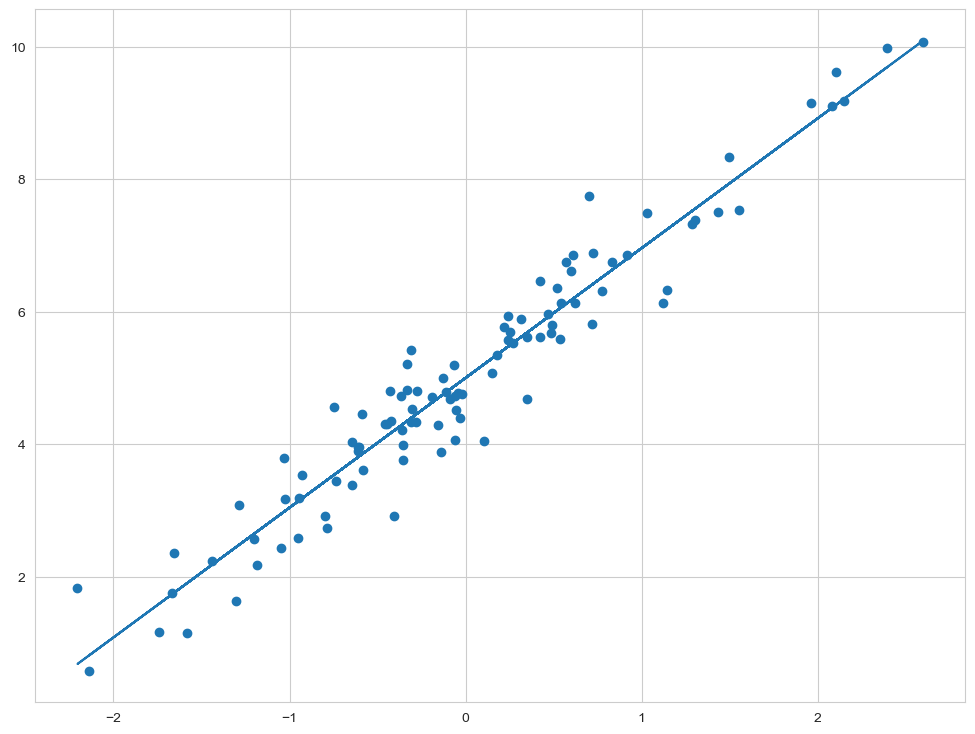

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [20]:
X_df = pd.DataFrame(data=X, columns=feature_names)
X_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


**Надо ли стандартизировать? В целом по разбросу значений в каждой колонке видно, что нужно, но проверю формально.**

In [21]:
for column in X_df:
    print(f'{column} mean:{X_df[column].mean()}; sd: {X_df[column].std()}')

MedInc mean:3.8706710029069766; sd: 1.8998217179452732
HouseAge mean:28.639486434108527; sd: 12.585557612111637
AveRooms mean:5.428999742190376; sd: 2.4741731394243205
AveBedrms mean:1.096675149606208; sd: 0.47391085679546435
Population mean:1425.4767441860465; sd: 1132.4621217653375
AveOccup mean:3.0706551594363742; sd: 10.386049562213591
Latitude mean:35.63186143410853; sd: 2.1359523974571117
Longitude mean:-119.56970445736432; sd: 2.003531723502581


**Действительно нужно**

**Что с корреляциями?**

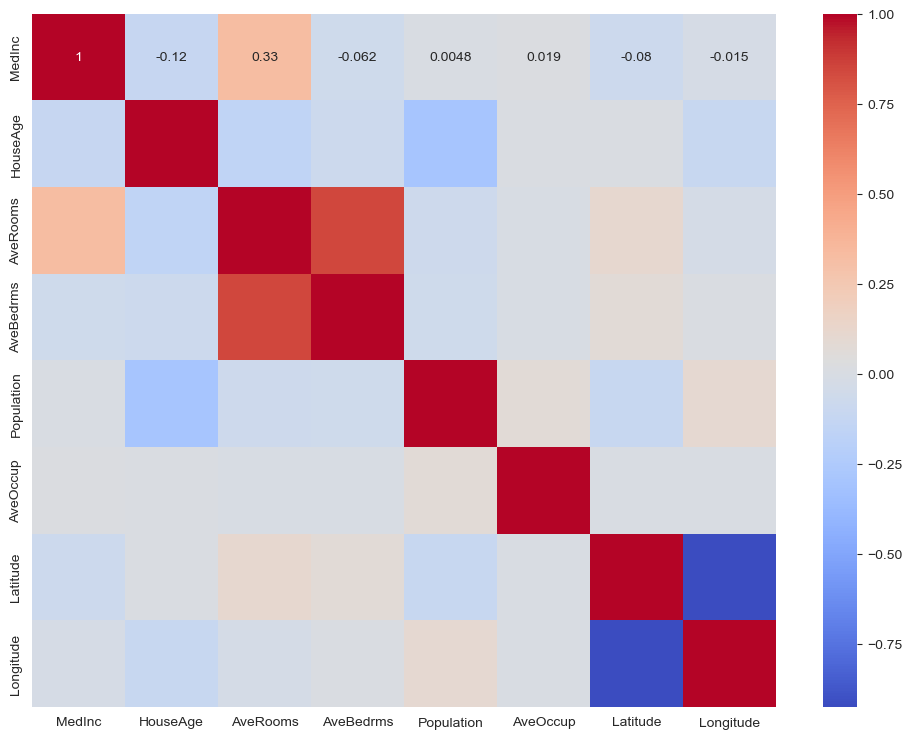

In [22]:
correlation_matrix = X_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  

plt.show()

**Есть пара сильных корреляций...**

In [23]:
#В корреляции AveRooms и AveBeds последняя перменная имеет меньший разброс и поэтому скорее всего будет менее значимой.
#Ну и это логично, что число спален будет связано с числом комнат
#Уберу эту переменную.
X_df_nobed = X_df.drop('AveBedrms', axis=1)

#Еще есть заметная отрицательная корреляция между Latitude и Longitude.
#Попробую оставить что-то одно
X_df_lat = X_df_nobed.drop('Longitude', axis=1)
X_df_lon = X_df_nobed.drop('Latitude', axis=1)

In [24]:
# Модель, где оставили Latitude:
lr_pipeline1 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(X_df_lat, y, test_size=0.2)
lr_pipeline1.fit(X_train_lat, y_train_lat)
y_pred_lat = lr_pipeline1.predict(X_test_lat)

In [25]:
# Модель, где оставили Longitude:
lr_pipeline2 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

X_train_lon, X_test_lon, y_train_lon, y_test_lon = train_test_split(X_df_lon, y, test_size=0.2)
lr_pipeline2.fit(X_train_lon, y_train_lon)
y_pred_lon = lr_pipeline2.predict(X_test_lon)

In [26]:
# Посмотрю метрики:
print('Oставил Latitude:')
print(f' r2: {r2_score(y_test_lat, y_pred_lat)}')
print(f' mse: {mean_squared_error(y_test_lat, y_pred_lat)} \n')

print('Oставил Longitude:')
print(f' r2: {r2_score(y_test_lon, y_pred_lon)}')
print(f' mse: {mean_squared_error(y_test_lon, y_pred_lon)}')

Oставил Latitude:
 r2: 0.5159450854992269
 mse: 0.6305448054782977 

Oставил Longitude:
 r2: 0.4935561855389925
 mse: 0.6662867463160215


**В общем, если оставить Latitude, то модель будет лучше.**

**А если не удалять ничего?**

In [27]:
lr_pipeline3 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lr_pipeline3.fit(X_train, y_train)
y_pred = lr_pipeline3.predict(X_test)

In [28]:
print('Oставил все:')
print(f' r2: {r2_score(y_test, y_pred)}')
print(f' mse: {mean_squared_error(y_test, y_pred)}')

Oставил все:
 r2: 0.5977901158599219
 mse: 0.5197139413112587


**На удивление, так лучше всего. Буду работать далее с этими данными**

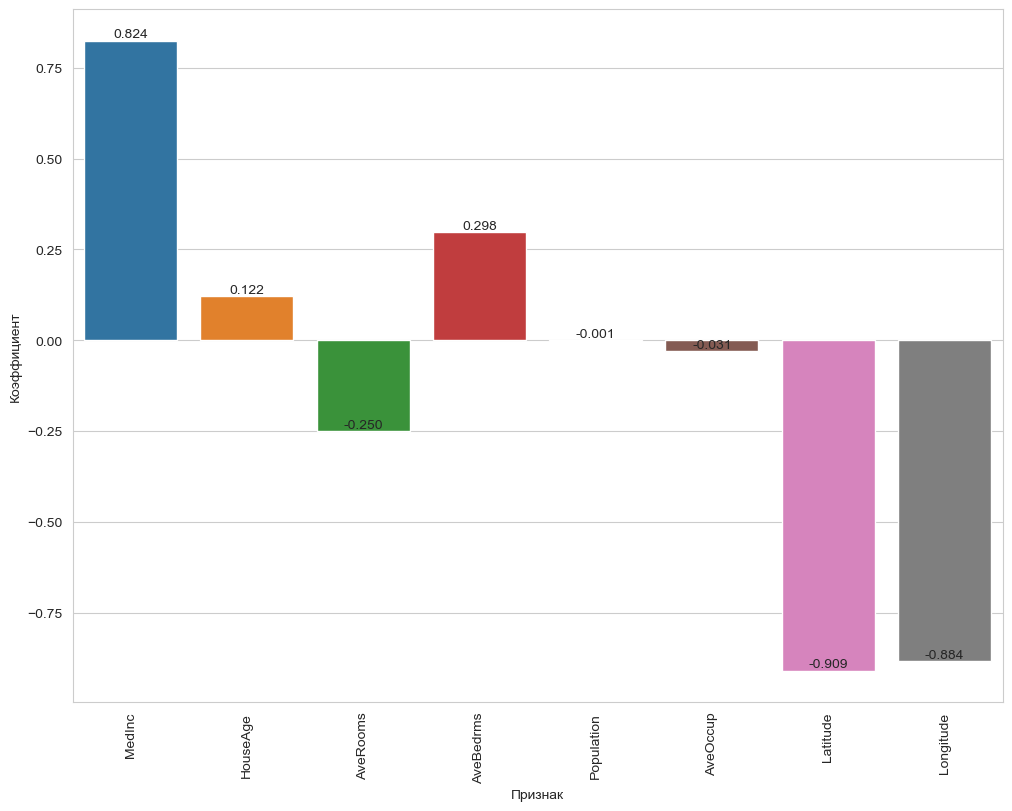

In [29]:
sns.barplot(x=X_df.columns, y=lr_pipeline3[1].coef_)

for i, coef in enumerate(lr_pipeline3[1].coef_):
    plt.text(i, coef, f'{coef:.3f}', ha='center', va='bottom')

plt.xlabel('Признак')
plt.ylabel('Коэффициент')
plt.xticks(rotation=90)
plt.show()

**Выходит, что Latitude, Longitude и MedInc - самые значимые признаки**

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [30]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    sigma = 1 / (1 + np.exp(-output))
    return sigma

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [31]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce_value = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / n
    return bce_value
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    bce_grad_value = X.T @ (y_pred - y_true)
    return bce_grad_value

class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [32]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return sigmoid(X_test @ self.W)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [33]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

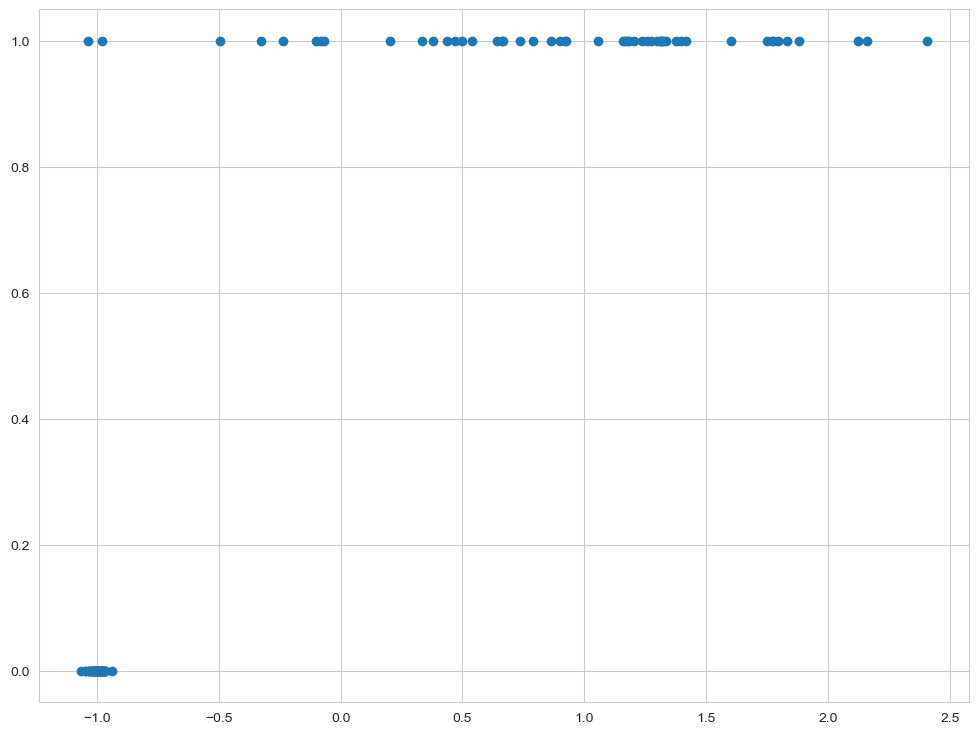

In [34]:
plt.scatter(X, y);

In [35]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

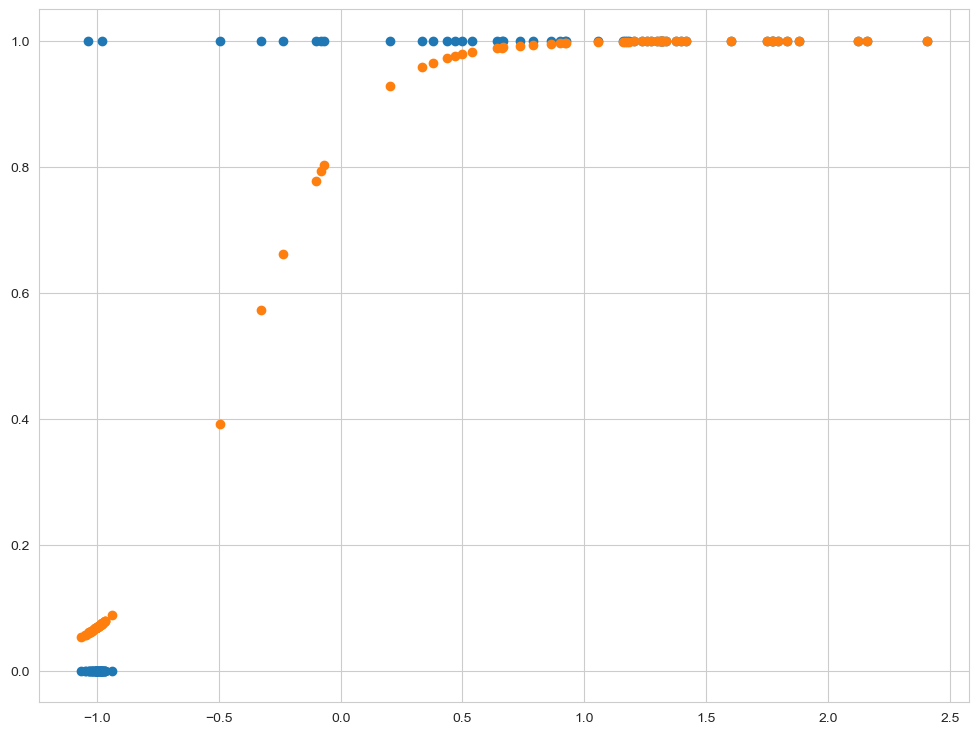

In [36]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
y_pred_binary = (y_pred > 0.5).astype('int64')

print(f'percision: {precision_score(y, y_pred_binary)}')
print(f'recall: {recall_score(y, y_pred_binary)}')
print(f'f1: {f1_score(y, y_pred_binary)}')
print(f'accuracy: {accuracy_score(y, y_pred_binary)}')

percision: 1.0
recall: 0.9423076923076923
f1: 0.9702970297029703
accuracy: 0.97


**Модель работает хорошо!**

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [38]:
pokemon = pd.read_csv("~/bioinf/BI_ML_2024/hw2/data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [39]:
pokemon['Legendary'] = pokemon['Legendary'].astype('int64')

In [40]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 81.4+ KB


In [41]:
# Уникальные значения:
for column in pokemon:
    unique_count = len(pokemon[column].unique())
    print(f'{column}: {unique_count} unique')

#: 721 unique
Name: 800 unique
Type 1: 18 unique
Type 2: 19 unique
Total: 200 unique
HP: 94 unique
Attack: 111 unique
Defense: 103 unique
Sp. Atk: 105 unique
Sp. Def: 92 unique
Speed: 108 unique
Generation: 6 unique
Legendary: 2 unique


**Исходя из моих глубоких знаний о покемонах: имя и ID (#) сразу имеет смысл выбросить, т.к. они должны быть уникальными (ID одинаковы для обычного покемона и его мега/гигантамакс и др. версий, но в любом случае их номер в покедексе (собственно ID) не должен как либо влиять на легендарность). Значение Total тоже можно сразу убрать, т.к. это просто сумма остальных характеристик покемона.**

In [42]:
pokemon = pokemon.drop('#', axis=1)
pokemon = pokemon.drop('Name', axis=1)
pokemon = pokemon.drop('Total', axis=1)
pokemon

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,45,49,49,65,65,45,1,0
1,Grass,Poison,60,62,63,80,80,60,1,0
2,Grass,Poison,80,82,83,100,100,80,1,0
3,Grass,Poison,80,100,123,122,120,80,1,0
4,Fire,NaN,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...
795,Rock,Fairy,50,100,150,100,150,50,6,1
796,Rock,Fairy,50,160,110,160,110,110,6,1
797,Psychic,Ghost,80,110,60,150,130,70,6,1
798,Psychic,Dark,80,160,60,170,130,80,6,1


**Параметр generation точно следует перевести в фактор (поколений покемонов всего 9, но тут 6). Типы покемона тоже следует перевести в фактор, причем во втором типе заменю пропущенные значения на `no_type2`.**

In [43]:
pokemon.fillna({'Type 2' :'no_type2'}, inplace = True)

**Посмотрю корреляции численных признаков**

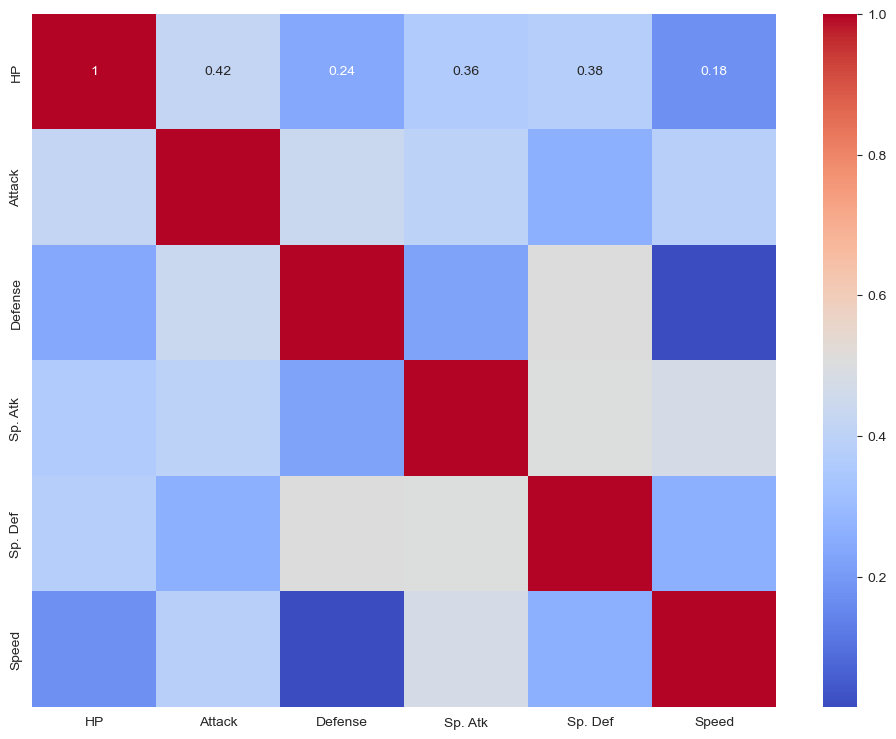

In [44]:
correlation_matrix = pokemon[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  

plt.show()

**Вроде все приемлимо**

In [45]:
cat_cols = ["Type 1", "Type 2", "Generation"]
num_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]

all_features = cat_cols + num_cols

X = pokemon[all_features]
y = pokemon["Legendary"].values

**Нужно ли стандартизовать?**

In [46]:
for column in X[num_cols]:
    print(f'{column} mean:{X[column].mean()}; sd: {X[column].std()}')

HP mean:69.25875; sd: 25.534669032332047
Attack mean:79.00125; sd: 32.45736586949843
Defense mean:73.8425; sd: 31.183500559332927
Sp. Atk mean:72.82; sd: 32.72229416880157
Sp. Def mean:71.9025; sd: 27.82891579711745
Speed mean:68.2775; sd: 29.06047371716149


**Выглядят очень схоже, но на всякий случай проведу стандартизацию**

Разделите ваши данные на тестовую и тренировочную выборку.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

Обучите модель `LogisticRegression` из `sklearn`.

In [48]:
#Модель
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])

lreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lregression", LogisticRegression())
])

lreg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['HP', 'Attack', 'Defense',
                                                   'Sp. Atk', 'Sp. Def',
                                                   'Speed']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Type 1', 'Type 2',
                                                   'Generation'])])),
                ('lregression', LogisticRegression())])

In [49]:
lreg_pipeline.fit(X_train, y_train)
y_pred = lreg_pipeline.predict(X_test)
y_prob = lreg_pipeline.predict_proba(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

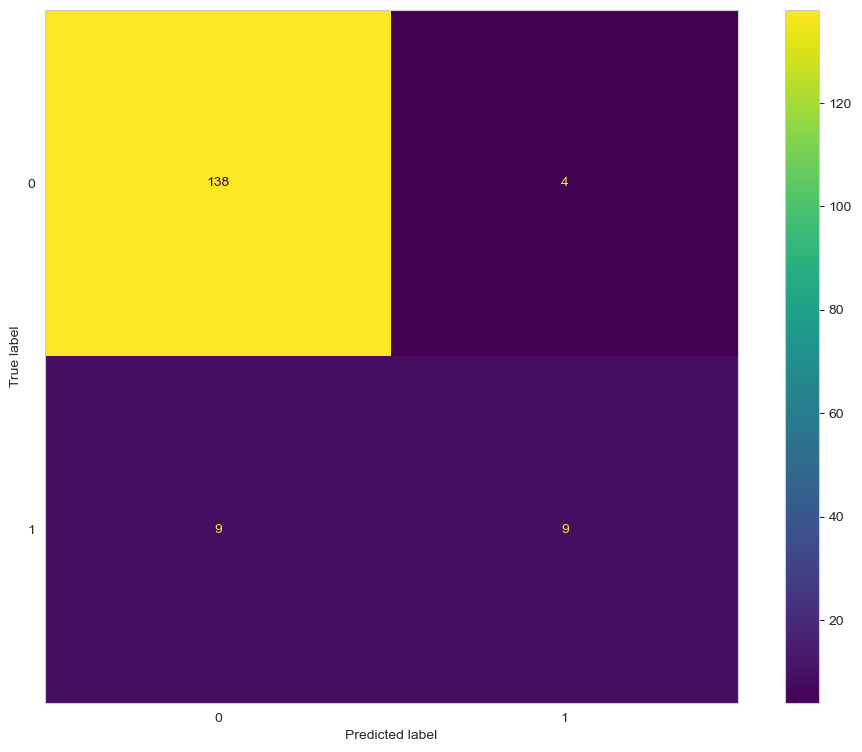

In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.grid(False);

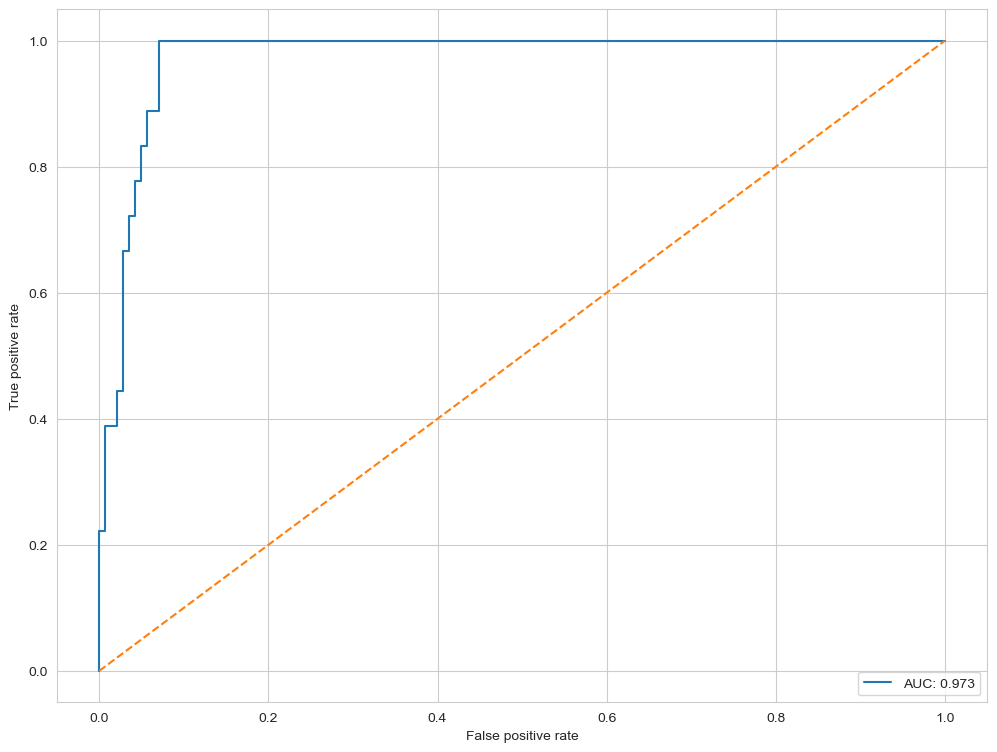

In [51]:
fpr,tpr,thresholds = roc_curve(y_test, y_prob[:, 1])

auc_result = f'AUC: {roc_auc_score(y_test, y_prob[:, 1]):.3f}'
plt.plot(fpr, tpr, label = auc_result)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

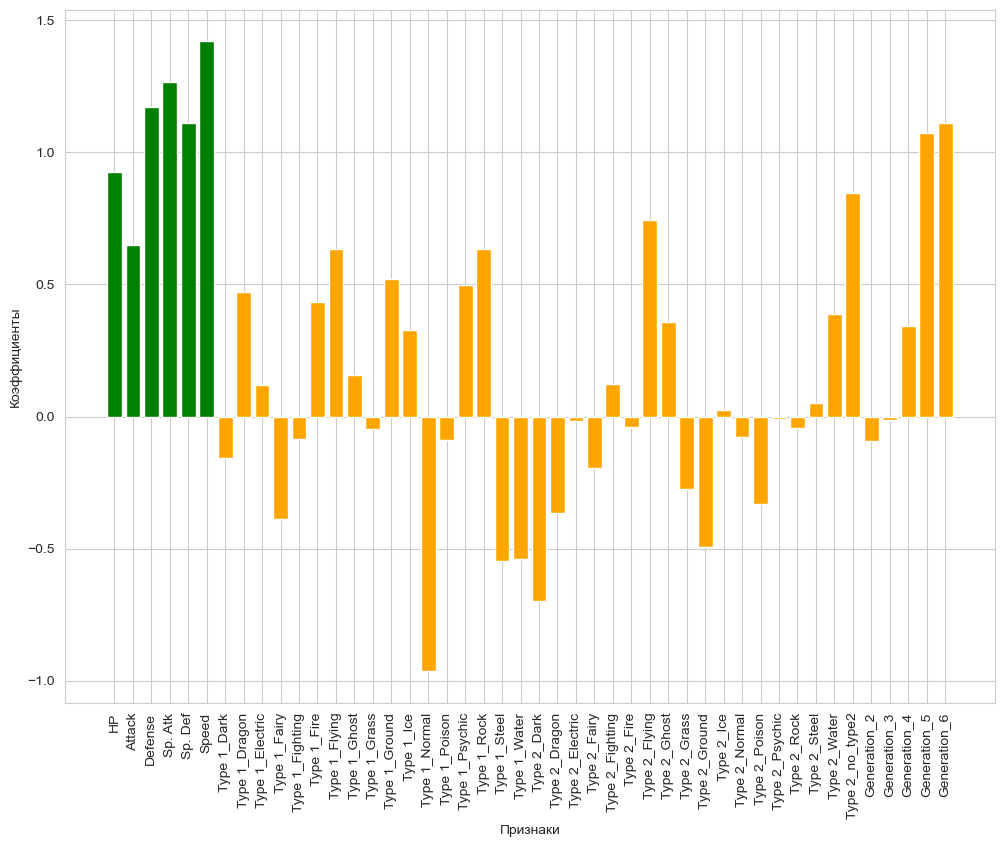

In [52]:
coef = lreg_pipeline[1].coef_

features = list(lreg_pipeline[0].transformers_[1][1].get_feature_names_out(input_features=cat_cols))
full_features = num_cols + features
colors = ['green'] * len(num_cols) + ['orange'] * len(features)

plt.bar(full_features, coef[0], color = colors)
plt.xlabel('Признаки')
plt.ylabel('Коэффициенты')
plt.xticks(rotation=90)
plt.show()

**Получилась жуткая гистограмма, но какие из нее выводы? Среди численных характеристик наибольший вклад имеют скорость (Speed), особая атака (Sp. Atk) и защита (Def). Разные типы также вносят вклад, так нормальный первый тип (Type 1 Normal) вносит отрицательный вклад в легендарность покемона, а отсутствие второго типа (Type 2 no type2) или летающий второй тип (Type 2 Flying) наоборот положительно влияют на легендарность. Также важно поколение.**

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Сложно так написать, т.к. у меня плейлист состоит из разных треков в разнобой, но наверное, это все таки Pixies. Познакомился с cd диска папы. Некоторые самые любимые (?) треки: [Monkey gone to heaven](https://www.youtube.com/watch?v=EHC9HE7vazI), [Hey](https://www.youtube.com/watch?v=tVCUAXOBF7w), [Human Crime](https://www.youtube.com/watch?v=l7ofPSefhyQ), [Here comes your man](https://www.youtube.com/watch?v=LKVrRzr6CM4).

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Боль, кровь, пот и ностальгия по покемонам)))). Если серьезно, то было интересно.